# Wind Correction
A Python notebook illustrating the math behind wind correction. 

(C) 2021 Kael HANSON

## Introduction
On cross-country flights, your airplane flies through the fluid we commonly call the atmosphere. In most real life situations, this fluid flows over the ground and complicates your job of navigating your craft from origin to destination. As even a private pilot, you are required to know how to account for this in your cross-country planning. The classical way of doing this is to manually fill in the sequence of waypoints along your route using a navigation planning sheet. Between each waypoint, find the magnetic bearing from your sectional chart, correct for magnetic variation, add the wind correction to get true heading and groundspeed, and then finally back out the magnetic variation to get from true to magnetic heading. This process is tedious and involves using an E6B or simple electronic flight computer which magically gives you the wind correction angle and groundspeed, provided the true course (hereafter TC), true airspeed (TAS), and wind speed and direction. 

Of course it's now 2021 and most of us, certainly the author of this article, use ForeFlight or other sophisticated EFB package to simplify the process immensely: just plug in the route, cruise altitude, ETD, and your aircraft performance specs, and within seconds you have a complete soltution for your route including time and fuel consumption. To be sure, I think it's important to know how to calculate the route manually because it ultimately gives you a better understanding of what's going on. But, just like I would probably opt to grab my calculator to find the product of 1,234 times 5,678 over writing it out in long multiplication, I almost always rely on ForeFlight to do the heavy lifting in my cross-country planning.

Nevertheless, in the spirit of knowing the machinery that underlies these computations, and as an amusing cross country trip over the green fields of vector math and trigonometry with Python as our guide, this notebook guides the interested reader toward a deeper understanding of wind correction. 

If you don't know what Python is or if you are a novice to programming, you should be able to ignore the code blocks. If you are Pythonically-enabled then you will find useful code, including some examples of technical diagramming using Matplotlib. I've been using this package for over a decade and only recently realized how usable it is in this context as well.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
import math

In [2]:
class compassvector:
    """
    Compass-oriented vector with support for MPL drawing. 0 is N, 90 E, 180 S, 270 W. 
    """
    def __init__(self, x=0, y=0, name=None):
        self.name = name
        self.x = x
        self.y = y
        
    def __repr__(self):
        return f'({self.x:f}, {self.y:f})'
    
    def __add__(self, v):
        return compassvector(self.x + v.x, self.y + v.y)
    
    def __sub__(self, v):
        return compassvector(self.x - v.x, self.y - v.y)
    
    def __neg__(self, v):
        return compassvector(-self.x, -self.y)
    
    @staticmethod
    def polar(mag, arg, name=None):
        a = math.radians(arg)
        return compassvector(mag*math.sin(a), mag*math.cos(a), name=name)
    
    def plot(self, ax, x0=0.0, y0=0.0, left=False):
        ax.arrow(x0, y0, self.x, self.y, head_width=3, head_length=7, 
                 length_includes_head=True, fc='k', ec='k')
        if self.name is not None:
            # find the vector orthogonal
            o_x = self.y
            o_y = -self.x
            if left:
                o_x *= -1.
                o_y *= -1.
            o_m = math.sqrt(o_x**2 + o_y**2)
            o_x = 8 * o_x / o_m
            o_y = 8 * o_y / o_m
            txt_x = x0 + 0.5*self.x + o_x
            txt_y = y0 + 0.5*self.y + o_y
            ax.text(txt_x, txt_y, r'$\vec{\mathbf{' + self.name + '}}$', ha='center', va='center', size=14)

## Vector Math

### Polar and North / East Component Representations
Velocities are so-called _vector_ physical quantities. This means they have a well-defined measure of how big they are, this is called _magnitude_, and a direction. This should be solidly familiar to pilots: your airplane's velocity has a _speed_, 115 kts cruising for a 172N, for example, and a direction usually measured in degrees clockwise from magnetic North. The same is true for wind, but we'll have to be a little careful later in dealing with wind because in aviation and marine contexts, wind direction points to where it's coming from and not where the wind is headed so it opposite in sense to aircraft velocity. Please note that in lay terms speed and velocity are often used interchangeably, but in physics there is a strict separation: speed is _always_ a scalar (not a vector, just a number); velocity is _always_ a vector.

Graphically you can think of vectors as directed line segments or arrows. The scheme for defining velocities I used above, namely, direction and magnitude, is called _polar coordinates_. In this system the vector is completely determined by a length and an angle from some reference which I will take as clockwise from North even though most physics problems go counter-clockwise from the x-axis. 

See the plot below which shows a vector of length 100 and direction 50&deg; East of North.

Equivalently we could determine the vector by its North and East components: physically this means that your airplane is traveling some number of nautical miles North over some time interval and simultaneously flying East some number of nautical miles not necessarily equal to the amount North. What about South or West? Those are just negative North and negative East, respectively. 

Again there is a graphical interpretation of the components: it is the projection of the arrow head through the dotted lines perpendicular to each axis and is also indicated in the plot.

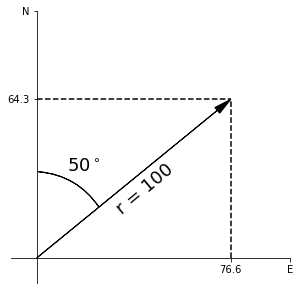

In [3]:
v = compassvector.polar(100, 50)

fig = plt.figure(figsize=(5, 5))
ax = fig.subplots(1, 1)
ax.set_xlim((-10, 100))
ax.set_ylim((-10, 100))
ax.set_xticks([v.x, 100])
ax.set_xticklabels([f'{v.x:.1f}', 'E'])
ax.set_yticks([v.y, 100])
ax.set_yticklabels([f'{v.y:.1f}', 'N'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

v.plot(ax)

# add annotations
arc = patches.FancyArrowPatch((25, 20), (0, 35), connectionstyle="arc3,rad=0.25")
ax.add_patch(arc)
ax.text(12, 35, r'$50^\circ$', size=18)
ax.text(30, 18, 'r = 100', rotation=40, size=18)
ax.plot((0, v.x), (v.y, v.y), 'k--')
ax.plot((v.x, v.x), (0, v.y), 'k--')

plt.show()

### Adding and Subtracting Vectors
#### Graphically

Vectors may be added and subtracted to produce another vector. Once more, there is a graphical interpretation of these mathematical operations. Looking at the figure below, the vector $\vec{\mathbf{t}}$ that results from adding vectors $\vec{\mathbf{h}}$ and $\vec{\mathbf{w}}$, mathematically denoted as 

$$\vec{\mathbf{t}} = \vec{\mathbf{h}} + \vec{\mathbf{w}}$$

is graphically found by placing the tail of the second vector on the head of the first (it doesn't matter which, remember that addition is commutative; order is not important) and then drawing the final vector sum from the tail of the first to the head of the second. It does matter how you choose the vector's head and tail: if you reverse them then you've inserted a negative sign in the vector and turned an addition into a subtraction! As long as you are careful, however, and use a ruler and protractor and properly respect a drawing scale you can use the graphical method to add and subtract vectors.

Subtraction is achieved by placing the second vector's head against the first vector's head and drawing the solution from the tail of the first to the tail of the second. You should be able to convince yourself that this is equivalent to adding the _negative_ of the second vector to the first by flipping the latter's tail and head around and is merely a rearrangement of the above equation:

$$\vec{\mathbf{h}} = \vec{\mathbf{t}} - \vec{\mathbf{w}}$$

Here you have to make sure you get the order right: just like subtracting numbers is not commutative, neither is vector subtraction.

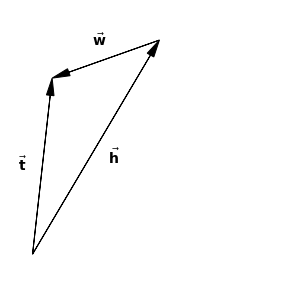

In [4]:
fig = plt.figure(figsize=(5, 5))
ax = fig.subplots(1, 1)
h = compassvector.polar(100, 30, name="h")
h.plot(ax)
w = compassvector.polar(45, 250, name="w")
w.plot(ax, x0=h.x, y0=h.y)
t = h + w
t.name = "t"
t.plot(ax, left=True)
plt.axis((-10, 100, -10, 100))
plt.axis('off')
plt.show()

#### Component-Wise Addition

Handling addition and subtraction of vectors is straightforward when the components are broken out into North and East components: to compute the sum of two vectors, express each as North and East components and sum up the North components to arrive at the North component of the summed vector and same for the East components. Likewise for subtraction: subtract the components component-wise.

$$
\eqalign{
    \vec{\mathbf{h}} &= h_N \, \hat{\mathbf{N}} + h_E \, \hat{\mathbf{E}}\cr
    \vec{\mathbf{w}} &= w_N \, \hat{\mathbf{N}} + w_E \, \hat{\mathbf{E}}\cr
    \vec{\mathbf{t}} &= (h_N + w_N) \, \hat{\mathbf{N}} + (h_E + w_E) \, \hat{\mathbf{E}}\cr
}
$$

If you find this notation opaque, so do I. It would be better to express this in terms of quantities you might find on your instrument panel or from a winds aloft forecast. So some definitions:

<dl>
    <dt>True Airspeed ($v_\mathrm{TAS}$)</dt>
    <dd>The aircraft's relative speed through the bulk airmass.</dd>
    <dt>True Heading ($\alpha$)</dt>
    <dd>Aircraft heading, corrected for magnetic variation.</dd>
    <dt>Bearing ($\beta$)</dt>
    <dd>Angle from true North from aircraft to waypoint or destination.</dd>
    <dt>Groundspeed ($v_\mathrm{GS}$)</dt>
    <dd>The speed of the aircraft over the ground.</dd>
    <dt>Windspeed ($v_W$)</dt>
    <dd>Magnitude of wind.</dd>
    <dt>Wind direction ($\gamma$)</dt>
    <dd>Direction of _origin_ of wind. So for a direct west wind out of 270&deg; $\gamma = 270^\circ$.</dd>
</dl>
    
In terms of these quantities the above vector component equations can be rewritten as

$$
\eqalign{
    \vec{\mathbf{h}} &= v_\mathrm{TAS} \left( \cos\alpha\,\hat{\mathbf{N}} + \sin\alpha\,\hat{\mathbf{E}} \right)\cr
    \vec{\mathbf{w}} &= -v_W \left( \cos\gamma\,\hat{\mathbf{N}} + \sin\gamma\,\hat{\mathbf{E}} \right)\cr
    \vec{\mathbf{t}} &= v_\mathrm{GS} \left( \cos\beta\,\hat{\mathbf{N}} + \sin\beta\,\hat{\mathbf{E}} \right)\cr
}
$$

## Wind Correction is a Vector Problem
So far I have been saying a lot about vectors and left you hanging on the subject of the title of this notebook. The Pilot's Handbook of Aeronautical Knowledge, Chapter 16, shows a diagram of an airplane flying in a wind. 

<img src="PHAK_Fig16-14.png"/>

Notice that this is the same (albeit, rotated) problem as the vector addition problem seen in the simple mathematical diagram above. The vector $\vec{\mathbf{t}}$ is the airplane's (ground) track that results from it's heading velocity vector, $\vec{\mathbf{h}}$, being added to the wind vector $\vec{\mathbf{w}}$. As a pillar of this notebook I am going to write it out again and also write it in **LARGE AND BOLD** English text:

$$\vec{\mathbf{t}} = \vec{\mathbf{h}} + \vec{\mathbf{w}}$$

<div align="center">
    <span style="font-size: 125%; font-weight: 500">
        GROUND TRACK VECTOR = AIRPLANE VELOCITY VECTOR + WIND VECTOR
    </span>
</div>

## Solving the Wind Correction Problem in Standard Form
At first glance it seems straightforward to solve the vector problem: just add the wind and the airplane's velocity and get the ground track. This is usually not how the problem is presented, however. Normally you know the wind speed and direction but you don't fully know the ground track velocity nor the aircraft velocity. You know the aircraft's TAS because you are optimizing power settings for that TAS but you don't know the heading you need to fly. Nor do you know _a priori_ the ground speed although you know the bearing. So the unknowns are $\alpha$ and $v_\mathrm{GS}$.

Using the form $\vec{\mathbf{h}} = \vec{\mathbf{t}} - \vec{\mathbf{w}}$, substituting the components expressed as above, and arriving at the two equations with two unknowns by requiring that the North and East components are separately equal in the vector equations:

$$
\eqalign{
    v_\mathrm{TAS} \cos\alpha &= v_\mathrm{GS} \cos\beta + v_W \cos\gamma \cr
    v_\mathrm{TAS} \sin\alpha &= v_\mathrm{GS} \sin\beta + v_W \sin\gamma \cr
}
$$

The standard trick to eliminate the unknown $\alpha$ is to square each equation and sum them using the trigonometric identity $\cos^2\alpha + \sin^2\alpha = 1$. This leaves:

$$
v_\mathrm{TAS}^2 = v_\mathrm{GS}^2 + v_W^2 + 2 v_\mathrm{GS}\cos\delta 
$$

Where $\delta \equiv \beta - \gamma$ is shorthand for the angle between the true course and the wind direction. This looks a lot like the Law of Cosines because it is. This is now a quadratic equation with solution:

$$v_\mathrm{GS} = -v_W \cos\delta + \sqrt{v_w^2\cos^2\delta + v_\mathrm{TAS}^2 - v_W^2}$$

The heading you must fly is 

$$ 
\tan\alpha = \frac{v_\mathrm{GS} \sin\beta + v_W \sin\gamma}{v_\mathrm{GS} \cos\beta + v_W \cos\gamma}
$$

Note this is your actual __heading__ and not the wind correction angle.

## Analysis
If you have a mathematical expression for a physical system then you are its master. Let's examine some special cases of the above solutions for ground speed and heading.

### Headwind 
Plugging in $\delta = 0^\circ$ gives you $v_\mathrm{GS} = -v_W + v_\mathrm{TAS}$ and $\tan\alpha = \tan\beta = \tan\gamma$. This is what you would expect: your heading is the bearing and your groundspeed is reduced by the headwind knot for knot.

### Tailwind
Likewise for $\delta = 180^\circ$ you fly the heading and your groundspeed is increased knot for knot by the wind.

### Direct cross 
For the case $\delta = 90^\circ$, $\cos\delta = 0$ so 

$$v_\mathrm{GS} = \sqrt{v_\mathrm{TAS}^2 - v_W^2} \simeq v_\mathrm{TAS}\left[1 - 
\frac{1}{2}\left(\frac{v_W}{v_\mathrm{TAS}}\right)^2\right]
$$ 

The wind triangle is now a right triangle (see figure below), with hypotenuse $v_\mathrm{TAS}$ formed by the mutually orthogonal sides $v_\mathrm{GS}$ and $v_W$. The wind correction angle is then

$$\psi = \sin\left(\frac{v_w}{v_\mathrm{TAS}}\right)$$

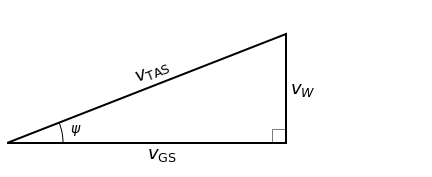

In [5]:
# Draw the right triangle
fig = plt.figure(figsize=(7.5, 3))
ax = fig.subplots(1, 1)
vertices = ( (0, 0), (10, 0), (10, 4), (0, 0) )
# Triangle as polygon patch plus the little square to represent the right angle
ax.add_patch(plt.Polygon(((9.5, 0), (9.5, 0.5), (10, 0.5)), False, fc='None', ec='k', lw=0.5))
ax.add_patch(plt.Polygon(vertices, True, fc='None', ec='k', lw=2))
# Annotations
ax.text(5, -0.6, r'$v_\mathrm{GS}$', size=18)
ax.text(10.15, 1.8, r'$v_W$', size=18)
ax.text(4.5, 2.25, r'$v_\mathrm{TAS}$', rotation=22, size=18)
ax.add_patch(patches.Arc((0, 0), 4, 4, theta1=0, theta2=22))
ax.text(2.25, 0.375, r'$\psi$', size=14)
plt.axis((0, 15, -1, 5))
plt.axis('off')
plt.show()

You might be surprised to learn that, for winds perpendicular to your desired bearing, you pick up a headwind approximately equal to half the ratio of the square of the windspeed to your TAS (e.g. if the crosswind is half of your TAS then the headwind component is one quarter of the windspeed). This is because you actually have to head slightly into the wind to maintain your ground track course. Having a faster airspeed reduces this effect.

## Wind Correction as a Python Function
The simple Python function below solves the above math for the standard wind correction problem. Note the use of the atan2 function to resolve the quadrant ambiguity of the arctangent.

In [6]:
def wind_correction(TAS, b, windspeed, wind_dir):
    """
    Given known airspeed, desired bearing, and wind find heading and ground speed.
    
    PARAMETERS
        TAS       - True airspeed
        b         - Bearing (degrees)
        windspeed - Wind speed
        wind_dir  - Direction wind is coming from
        
    RETURN
        v_gs, h   - ground speed and heading
    """
    b_rad = math.radians(b)
    w_rad = math.radians(wind_dir)
    cos_d = math.cos(b_rad - w_rad)
    B     = -windspeed * cos_d
    v_gs  = B + math.sqrt(B**2 + TAS**2 - windspeed**2)
    d_x   = v_gs * math.cos(b_rad) + windspeed * math.cos(w_rad)
    d_y   = v_gs * math.sin(b_rad) + windspeed * math.sin(w_rad)
    head  = math.degrees(math.atan2(d_y, d_x))
    if head < 0: head += 360
    return v_gs, head

In [9]:
v_gs, head = wind_correction(115, 355, 24, 250)
print(f'Heading {int(head+0.5):d}, ground speed {int(v_gs+0.5):d} kts')

Heading 343, ground speed 119 kts
